# Importing require libraries and pyspark setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from calendar import weekday
from datetime import datetime, date
from pandas.tseries.holiday import USFederalHolidayCalendar as calander
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

In [2]:
spark = (
    SparkSession.builder.appName("preprocessing of taxi data")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

22/08/25 19:30:00 WARN Utils: Your hostname, kams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.117.182 instead (on interface en0)
22/08/25 19:30:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/25 19:30:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Reading in data, and a quick check on the processed data.

In [3]:
taxi_sdf = spark.read.parquet('../data/curated/preprocess_taxi_result1')
weather_sdf = spark.read.parquet('../data/curated/preprocess_weather_result1')

In [4]:
taxi_sdf.printSchema()

root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- duration (minutes): double (nullable = true)



# Obtaining date, time, year, month, and day from pickup datetime
This is done to allow easier feature engineering in terms of coding purpose, but also to capture underlying relationships of data.

In [5]:
taxi_sdf = taxi_sdf.withColumn("date", F.to_date(F.col('tpep_pickup_datetime')))
taxi_sdf = taxi_sdf.withColumn("time", F.date_format('tpep_pickup_datetime', 'HH:mm:ss'))
taxi_sdf = taxi_sdf.withColumn("year", F.date_format('tpep_pickup_datetime', 'yyyy'))
taxi_sdf = taxi_sdf.withColumn("month", F.date_format('tpep_pickup_datetime', 'MM'))
taxi_sdf = taxi_sdf.withColumn("day", F.date_format('tpep_pickup_datetime', 'dd'))
taxi_sdf


tpep_pickup_datetime,PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day
2016-03-01 00:06:22,43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01
2016-03-01 00:23:21,237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01
2016-03-01 00:37:19,236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01
2016-03-01 00:34:53,95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01
2016-03-01 00:30:27,170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01
2016-03-01 00:09:43,163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01
2016-03-01 00:32:15,163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01
2016-03-01 00:02:37,142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01
2016-03-01 00:50:58,239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01
2016-03-01 00:06:17,164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01


In [6]:
weather_sdf

datetime,average_temperature,precip
2016-01-01,3.75,0
2016-01-02,2.55,0
2016-01-03,4.4,0
2016-01-04,-3.4,0
2016-01-05,-6.55,0
2016-01-06,0.3,0
2016-01-07,3.8,0
2016-01-08,4.3,0
2016-01-09,6.5,0.05
2016-01-10,10.0,40.9


# Merging weather dataset and taxi dataset based on date 
This is done to simplify the process of feature engineering and preparing a training dataset

In [7]:
join_sdf = taxi_sdf.join(weather_sdf, taxi_sdf.date == weather_sdf.datetime, "left")

In [8]:
feature_eng_sdf = join_sdf.drop("tpep_pickup_datetime", "datetime")
feature_eng_sdf.show()

+------------+-----------+-----+----------+------------------+----------+--------+----+-----+---+-------------------+------+
|PULocationID|fare_amount|extra|tip_amount|duration (minutes)|      date|    time|year|month|day|average_temperature|precip|
+------------+-----------+-----+----------+------------------+----------+--------+----+-----+---+-------------------+------+
|          43|        6.5|  0.5|       0.0|             4.333|2016-03-01|00:06:22|2016|   03| 01|                7.2|     0|
|         237|        8.5|  0.5|      1.96|             5.617|2016-03-01|00:23:21|2016|   03| 01|                7.2|     0|
|         236|        8.0|  0.5|      1.86|             6.867|2016-03-01|00:37:19|2016|   03| 01|                7.2|     0|
|          95|       13.0|  0.5|       2.5|             11.35|2016-03-01|00:34:53|2016|   03| 01|                7.2|     0|
|         170|       20.5|  0.5|      4.35|              22.7|2016-03-01|00:30:27|2016|   03| 01|                7.2|     0|


# Creating visualisation of month against total value of trips in 2016
This is done to investigate the relationship that may be hidden the data set.

In [9]:
visualise_month_pickups_sdf = feature_eng_sdf.filter(F.col("date") <= "2016-12-31")
# get total amount of trips according to month.
visualise_month_pickups_sdf = visualise_month_pickups_sdf.groupBy("month") \
                                                     .agg(
                                                         {
                                                             "month": "count",
                                                        }
                                                     ) \
                                                     .withColumnRenamed('count(month)', 'total_trips') 
visualise_month_pickups_df = visualise_month_pickups_sdf.toPandas()

Plotting a line graph, to provide insight of the relationship.

/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_81504/4013854996.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(x, y, Marker='o')


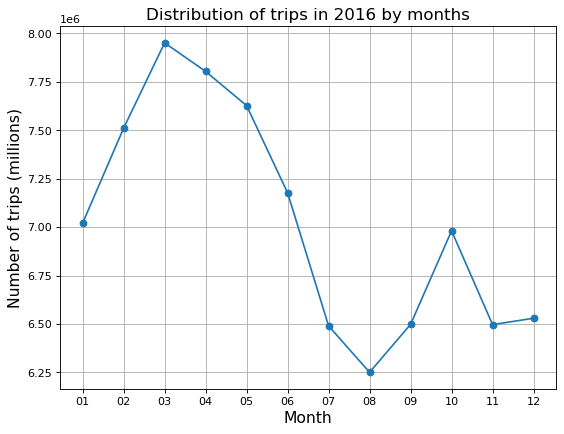

In [10]:
figure(figsize=(8, 6), dpi=80)
visualise_month_pickups_df = visualise_month_pickups_df.sort_values(by=['month'])
x = visualise_month_pickups_df['month']
y = visualise_month_pickups_df['total_trips']
plt.title("Distribution of trips in 2016 by months", fontsize=15)
plt.grid(b=True)
plt.ylabel("Number of trips (millions)", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.plot(x, y, Marker='o')
plt.savefig("../plots/pickup_month.png", bbox_inches = "tight")

# Normalise time with the purpose of seperating it under a 24 hour bin

In [11]:
@F.udf(returnType=FloatType())
def normalize_time(time):
    """ normalized time in to a floating point between 0 and 1 that is binned 
        into the middle of the bin, 24 bins.

    Args:
        time (string): a string that describe time in the form of HH:mm:ss

    Returns:
        float: standardised time
    """
    BIN = 24
    hour, min, sec = time.split(':')

    return (int(hour) + 0.5) / BIN

feature_eng_sdf = feature_eng_sdf.withColumn("time_float", normalize_time(F.col("time")))

In [12]:
@F.udf(returnType=FloatType())
def cos_val(value):
    """ convert value to cosine value

    Args:
        time (float): a float value that is between 0 and 1

    Returns:
        float: value in cosine value
    """
    cos_time = math.cos(2 * math.pi * value)
    
    return cos_time

@F.udf(returnType=FloatType())
def sin_val(value):
    """ convert value to sin value

    Args:
        time (float): a float value that is between 0 and 1

    Returns:
        float: value in sin value
    """
    sin_time = math.sin(2 * math.pi * value)
    
    return sin_time

Since time is a cyclical feature, cosine and sine transformation is performed retain the cyclical pattern

In [13]:
feature_eng_sdf = feature_eng_sdf.withColumn("cos_time", cos_val(F.col("time_float")))
feature_eng_sdf = feature_eng_sdf.withColumn("sin_time", sin_val(F.col("time_float")))
feature_eng_sdf

PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619


# Visualising weekday and time's relationship with trip amount

In [14]:
@F.udf(returnType=StringType())
def covert_day(year, month, day):
    """ Taking a day in a year and transforming it 
    into its respective weekday

    Args:
        year (string):  'yyyy'
        month (string): 'mm'
        day (string): 'dd'

    Returns:
        string: weekday (Monday, Tuesday etc.)
    """
    day_int = weekday(int(year), int(month), int(day))
    day_to_str = {0: "Monday",
                  1: "Tuesday",
                  2: "Wednesday",
                  3: "Thursday",
                  4: "Friday",
                  5: "Saturday",
                  6: "Sunday"}
    return day_to_str[day_int]


# based on iterest, group by weekday and time for visualisation
visualise_day_time_pickups_sdf = feature_eng_sdf.withColumn("day_of_week", covert_day(F.col("year"), F.col("month"), F.col("day")))
visualise_day_time_pickups_sdf =visualise_day_time_pickups_sdf.groupBy("day_of_week", "time_float") \
                                                     .agg(
                                                         {
                                                             "month": "count",
                                                             "time" : "first"
                                                        }
                                                     ) \
                                                     .withColumnRenamed('count(month)', 'total_trips') \
                                                     .withColumnRenamed('first(time)', 'time')
visualise_day_time_pickups_sdf

day_of_week,time_float,total_trips,time
Friday,0.020833334,725678,00:11:22
Friday,0.0625,457989,01:02:20
Friday,0.104166664,288720,02:00:36
Friday,0.14583333,183127,03:10:40
Friday,0.1875,143080,04:40:09
Friday,0.22916667,189575,05:34:26
Friday,0.27083334,465945,06:56:25
Friday,0.3125,836009,07:25:41
Friday,0.35416666,1018249,08:51:51
Friday,0.39583334,922375,09:07:41


In [15]:
@F.udf(returnType=StringType())
def gethour(time):
    """ Return the hour of a time

    Args:
        time (datetime): time in the form of "HH:mm:ss"

    Returns:
        string: hour in string
    """
    hour, min, sec = time.split(':')
    return f'{hour}:00'
visualise_day_time_pickups_sdf = visualise_day_time_pickups_sdf.withColumn('time', gethour(F.col('time')))
visualise_day_time_pickups_sdf

day_of_week,time_float,total_trips,time
Friday,0.020833334,725678,00:00
Friday,0.0625,457989,01:00
Friday,0.104166664,288720,02:00
Friday,0.14583333,183127,03:00
Friday,0.1875,143080,04:00
Friday,0.22916667,189575,05:00
Friday,0.27083334,465945,06:00
Friday,0.3125,836009,07:00
Friday,0.35416666,1018249,08:00
Friday,0.39583334,922375,09:00


The following code provides a heat map of time and weekday against pickups

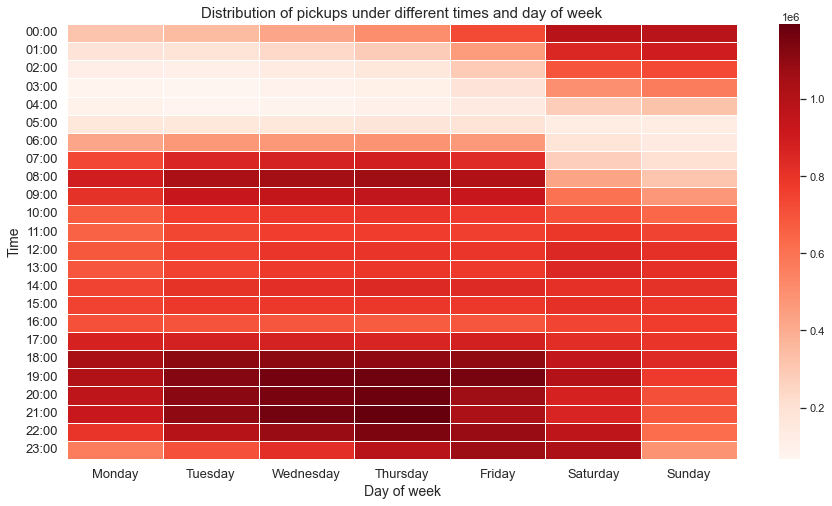

In [16]:
WEEK_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
visualise_day_time_pickups_df = visualise_day_time_pickups_sdf.toPandas()
# allowing week day to be sort by the actual weekday order
visualise_day_time_pickups_df['day_of_week'] = pd.Categorical(visualise_day_time_pickups_df['day_of_week'], 
                                                              categories=WEEK_NAMES)
visualise_day_time_pickups_df = visualise_day_time_pickups_df.sort_values(['day_of_week', 'time_float'])  
# pivoting on attributes of interest          
plot_df = pd.pivot_table(visualise_day_time_pickups_df, index='time', columns='day_of_week', values='total_trips', aggfunc=np.sum)

# plotting
sns.set(rc = {'figure.figsize':(15,8)})
plot = sns.heatmap(plot_df, xticklabels=True, yticklabels=True, linewidths=.5, cmap="Reds")
plot.set_xlabel("Day of week", fontsize=14)
plot.set_ylabel("Time", fontsize=14)
plot.set_title("Distribution of pickups under different times and day of week", fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.savefig("../plots/pickup_heatmap.png", bbox_inches = "tight")

# Normalizing weekday and hour
As shown by the above figure, it is evident that there exist relationships between the attributes, hence, such information is capture to allow the model when training to be more generalise.

In [17]:
@F.udf(returnType=FloatType())
def normalize_day(time_float, year, month, day):
    """ normalized day and time of the week into a float 
        between 1 and 0, where monday is represent as 0 
        and 6 for sunday, plus the addidtion of time float.

    Args:
        time (float): normalized time in 0 to 1
        year (string): string reprsentation for year
        month (string): string reprsentation for month
        day (string): string reprsentation for day

    Returns:
        float: day of week into a float between 1 and 0.
    """
    DAYS_WEEK = 7
    day_int = weekday(int(year), int(month), int(day))
    date_float = (day_int + time_float) / DAYS_WEEK
    
    return date_float

Since weekday-time is a cyclical feature, cosine and sine transformation is performed retain the cyclical pattern

In [18]:
feature_eng_sdf = feature_eng_sdf.withColumn("date_float", normalize_day(F.col("time_float"), F.col("year"), F.col("month"), F.col("day")))
feature_eng_sdf = feature_eng_sdf.withColumn("cos_date", cos_val(F.col("date_float")))
feature_eng_sdf = feature_eng_sdf.withColumn("sin_date", sin_val(F.col("date_float")))
feature_eng_sdf

PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time,date_float,cos_date,sin_date
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533


# From the month figure it shows that there exist relationship, thus, normalized.

In [19]:
@F.udf(returnType=FloatType())
def normalize_month(month):
    """normalized month into a fraction of 12 months

    Args:
        month (string): string reprsentation for month

    Returns:
        float: float between 0 to 1 to represent month
    """
    return float((int(month) - 1) / 12)

In [20]:
# again, month is cyclical thus sine and cosine is used for transformation
feature_eng_sdf = feature_eng_sdf.withColumn("month_float", normalize_month(F.col("month")))
feature_eng_sdf = feature_eng_sdf.withColumn("cos_month", cos_val(F.col("month_float")))
feature_eng_sdf = feature_eng_sdf.withColumn("sin_month", sin_val(F.col("month_float")))
feature_eng_sdf 

PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time,date_float,cos_date,sin_date,month_float,cos_month,sin_month
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,7.2,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254


# Convert average temperature into Fahrenheit

In [21]:
feature_eng_sdf = feature_eng_sdf.withColumn("average_temperature", (F.col("average_temperature") * 1.8) + 32)
feature_eng_sdf

PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time,date_float,cos_date,sin_date,month_float,cos_month,sin_month
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254


# Trip value calculation
Trip value is first defined as the sum of fare amounts divided by duration, trip value suffers a loss of 10% when 20F to 75F and 15% loss below 20F. Assume standard fuel economy is 25.4 mpg, then light rain (<2.5mm/hr percipitation) increase consumption by 0.25mpg is 1% loss, 2.5 to 7.5mm/hr is moderate rain assume 2% loss, 7.6 to 55mmm/hr as 4% loss.

In [22]:
@F.udf(returnType=FloatType())
def calc_trip_value(tip, fare, extra, duration, rain, temp):
    rain = float(rain)
    temp = float(temp)
    trip_value = (float(tip) + float(fare) + float(extra)) / float(duration)
    
    if temp < 20:
        trip_value *= 0.85
    elif temp < 75 and temp > 20:
        trip_value *= 0.9
    
    if rain < 2.5:
        trip_value *= 0.99
    elif rain < 7.5 and rain >= 2.5:
        trip_value *= 0.98
    else:
        trip_value *= 0.96
    
    return trip_value

In [23]:
# using desiring attributes to calculate the trip value
feature_eng_sdf = feature_eng_sdf.withColumn("trip_value", 
                                calc_trip_value(F.col("tip_amount"), 
                                F.col("fare_amount"),
                                F.col("extra"),
                                F.col("duration (minutes)"),
                                F.col("average_temperature"),
                                F.col("precip")
                                ))
feature_eng_sdf 


PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time,date_float,cos_date,sin_date,month_float,cos_month,sin_month,trip_value
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.3182553
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.5921952
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.2310703
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.1503084
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.9112599
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.1436535
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.92851675
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.0804023
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.224
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.9801091


# Holiday for added information, by common sense, holidays allows more trips to be taken.

In [24]:
# obtaining US federal holidays and label trips where they occur on a holiday
cal = calander()
holidays = cal.holidays(start='2016-01-01', end='2017-05-31')
holidays = [str(day).split()[0] for day in holidays]
feature_eng_sdf = feature_eng_sdf.withColumn("holiday",    
                                       F.when(F.col("date").isin(holidays), True)
                                       .otherwise(False)
                                      )


In [25]:
feature_eng_sdf

PULocationID,fare_amount,extra,tip_amount,duration (minutes),date,time,year,month,day,average_temperature,precip,time_float,cos_time,sin_time,date_float,cos_date,sin_date,month_float,cos_month,sin_month,trip_value,holiday
43,6.5,0.5,0.0,4.333,2016-03-01,00:06:22,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.3182553,false
237,8.5,0.5,1.96,5.617,2016-03-01,00:23:21,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.5921952,false
236,8.0,0.5,1.86,6.867,2016-03-01,00:37:19,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.2310703,false
95,13.0,0.5,2.5,11.35,2016-03-01,00:34:53,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.1503084,false
170,20.5,0.5,4.35,22.7,2016-03-01,00:30:27,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.9112599,false
163,9.0,0.5,3.09,8.983,2016-03-01,00:09:43,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.1436535,false
163,7.0,0.5,1.66,8.05,2016-03-01,00:32:15,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.92851675,false
142,29.0,0.5,6.05,26.85,2016-03-01,00:02:37,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.0804023,false
239,8.0,0.5,1.85,6.9,2016-03-01,00:50:58,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,1.224,false
164,8.0,0.5,1.85,8.617,2016-03-01,00:06:17,2016,03,01,44.96,0,0.020833334,0.9914449,0.13052619,0.14583333,0.6087614,0.7933533,0.16666667,0.5,0.8660254,0.9801091,false


In [26]:
feature_eng_sdf.write.mode('overwrite').parquet('../data/curated/feature_engineered')